In [1]:
%matplotlib inline
%config IPCompleter.greedy=True
import mysql.connector,os
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.font_manager import FontProperties
import pandas as pd
import numpy as np
from scipy.stats.stats import pearsonr
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,accuracy_score,f1_score
from imblearn.over_sampling import RandomOverSampler
from scipy.spatial.distance import cdist
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
import pickle

warnings.filterwarnings('ignore')

mydb = mysql.connector.connect(
    host="10.237.27.243",
    user="ictd",
    database="6th_eco_census"
)

mycursor = mydb.cursor(buffered=True)

In [2]:
#returns rows as list of tuples 
def runsql(sql):
    global mycursor
    mycursor.execute(sql)
    return mycursor.fetchall()
runsql("show tables")

[(bytearray(b'aggregate_senti'),),
 (bytearray(b'dist_sect_articles'),),
 (bytearray(b'dist_sect_est_emp'),),
 (bytearray(b'district_id'),),
 (bytearray(b'establishments'),),
 (bytearray(b'nic'),),
 (bytearray(b'nic_to_sec'),),
 (bytearray(b'ownership'),),
 (bytearray(b'sector_id'),),
 (bytearray(b'state_id'),)]

In [3]:
#district picker
def get_dist_id(name):
    return runsql("select district_id from district_id where district_name = "+"\""+name+"\"")[0][0]

def get_dist_name(id):
    return runsql("select district_name from district_id where district_id = "+"\""+id+"\"")[0][0]

def get_sector_name(id):
    return runsql("select name from sector_id where id = "+str(id))[0][0]

In [4]:
#take dist_sect no of establishments from database and save table as csv
if "dist_sect_est.csv" not in os.listdir():
    data = ""
    mycursor.execute("Select district_id,sector_id,no_establishments from dist_sect_est_emp")
    res = mycursor.fetchall()
    for r in res:
        data += ",".join(list(map(str,r)))+"\n"
    data = data[:-1]
    open("./dist_sect_est.csv",'w').write(data)
else:
    print("Already exists dist_sect_est.csv")

Already exists dist_sect_est.csv


In [5]:
#convert saved table csv to useful form
if "dist_sect_est_frame.csv" not in os.listdir("./"):
    print("making dataframe csv")
    df = pd.read_csv("./dist_sect_est.csv",index_col=False,dtype=str)
    # data = ""
    # sect_id = list(range(1,20))
    # dist_id = set(df.index)
    # df.index[16][0]
    dist_id = set(df["dist_id"])
    sect_id = list(range(1,20))

    out = "District_name,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19\n"
    for d in dist_id:
        line = get_dist_name(d)+','
        for s in sect_id:
            try:
                row = list(df[(df["dist_id"] == d) & (df["sect_id"] == str(s))].iloc[0])[2]
                line += row+","
            except:
                line += '0,'
        out += line[:-1]+"\n"

    open("./dist_sect_est_frame.csv",'w').write(out[:-1])

else:
    print("csv already exists dist_sect_est_frame.csv")


csv already exists dist_sect_est_frame.csv


In [6]:
# #create data frame from useful csv and start playing with it
# df_est = pd.read_csv("./dist_sect_est_frame.csv",index_col=0)
# df_est = round(df_est.div(df_est.sum(axis=1), axis=0)*100,2)
# df_foo = df_est
# df_foo = df_foo.apply(np.square)
# df_foo["HHI"] = df_foo.sum(axis=1)
# df_est["HHI"] = round(df_foo["HHI"],2)
# df_est

In [7]:
# #HHI_est analysis
# print("Competitive :",len(df_est[df_est["HHI"]<=1800]))
# print("Oligopoly :",len(df_est[(df_est["HHI"]>1800) & (df_est["HHI"] <= 3000)]))
# print("Monopoly :",len(df_est[df_est["HHI"]>3000]))

In [8]:
#take dist_sect no of employment from database and save table as csv
if "dist_sect_emp.csv" not in os.listdir():
    data = ""
    mycursor.execute("Select district_id,sector_id,sum_employment_lower, sum_employment_upper from dist_sect_est_emp")
    res = mycursor.fetchall()
    for r in res:
        data += str(r[0])+","+str(r[1])+","+str(int((float(r[2])+float(r[3]))/2))+"\n"
    data = data[:-1]
    open("./dist_sect_emp.csv",'w').write("dist_id,sect_id,no_emp\n"+data)
else:
    print("Already exists dist_sect_emp.csv")

Already exists dist_sect_emp.csv


In [9]:
#convert saved table csv to useful form
if "dist_sect_emp_frame.csv" not in os.listdir("./"):
    print("making dataframe csv")
    df = pd.read_csv("./dist_sect_emp.csv",index_col=False,dtype=str)
    # data = ""
    # sect_id = list(range(1,20))
    # dist_id = set(df.index)
    # df.index[16][0]
    dist_id = set(df["dist_id"])
    sect_id = list(range(1,20))

    out = "District_name,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19\n"
    for d in dist_id:
        line = get_dist_name(d)+','
        for s in sect_id:
            try:
                row = list(df[(df["dist_id"] == d) & (df["sect_id"] == str(s))].iloc[0])[2]
                line += row+","
            except:
                line += '0,'
        out += line[:-1]+"\n"

    open("./dist_sect_emp_frame.csv",'w').write(out[:-1])

else:
    print("csv already exists dist_sect_emp_frame.csv")


csv already exists dist_sect_emp_frame.csv


In [10]:
#take dist_sect no. of articles from database and save table as csv
if "dist_sect_art.csv" not in os.listdir():
    data = ""
    mycursor.execute("Select district_id,sector_id,total from aggregate_senti")
    res = mycursor.fetchall()
    for r in res:
        data += str(r[0])+","+str(r[1])+","+str(r[2])+"\n"
    data = data[:-1]
    open("./dist_sect_art.csv",'w').write("dist_id,sect_id,no_art\n"+data)
else:
    print("Already exists dist_sect_art.csv")

Already exists dist_sect_art.csv


In [11]:
#convert saved table csv to useful form
if "dist_sect_art_frame.csv" not in os.listdir("./"):
    print("making dataframe csv")
    df = pd.read_csv("./dist_sect_art.csv",index_col=False,dtype=str)
    dist_id = set(df["dist_id"])
    sect_id = list(range(1,20))
    
    count = 0
    out = "District_name,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19\n"
    total = 0
    for d in dist_id:
        sub_frame = df[df["dist_id"] == d]
#         print(sub_frame)
        
        line = get_dist_name(d)+','
        for s in sect_id:
            row = df[(df["dist_id"] == d) & (df["sect_id"] == str(s))]
            if len(row) == 0:
                line += '0,'
                continue
            line += str(row["no_art"].apply(int).sum())+","
            total += row["no_art"].apply(int).sum()
            count += len(row)

        out += line[:-1]+"\n"
    print("total rows",count)
    print("processed articles",total)

    open("./dist_sect_art_frame.csv",'w').write(out[:-1])

else:
    print("csv already exists dist_sect_art_frame.csv")


csv already exists dist_sect_art_frame.csv


In [12]:
#pruning the districts
pruned_dist = set()

# #update pruned dist from emp
df_emp = pd.read_csv("./dist_sect_emp_frame.csv",index_col=0)
# df_emp["total"] = df_emp.sum(axis=1)
# total_total_emp = df_emp["total"].sum()
# df_emp["total"] = df_emp["total"].apply(lambda x : round(x*100/total_total_emp,2))
# remaining_from_emp = set(df_emp[df_emp["total"] >= 0.10].index)
# print("Remainig from emp",len(remaining_from_emp))
# pruned_dist = pruned_dist.union(set(df_emp.index).difference(remaining_from_emp))


#update pruned dist from art
df_art = pd.read_csv("./dist_sect_art_frame.csv",index_col=0)
df_art["total"] = df_art.sum(axis=1)
total_total_art = df_art["total"].sum()
df_art = df_art[df_art["total"] >= 100]
remaining_from_art = set(df_art[df_art["total"] >= 0.10].index)

#common_dist_names contains all districts which we deal with
common_dist_names = set(remaining_from_art).intersection(set(df_emp.index))
#delhi was creating problem as it is in articles as whole 
#in employment,census it is divided in 5 districts
common_dist_names.remove("Delhi")

print("Common no of districts",len(common_dist_names))

Common no of districts 157


In [13]:
#duplicated districts
df_emp = pd.read_csv("./dist_sect_emp_frame.csv",index_col=0)
series_agri = pd.read_excel("./agri_emp.xlsx", index_col=0)[["ag_pop"]]
#convert this dataframe into series
series_agri = series_agri.squeeze()
duplicated_districts = set(series_agri[series_agri.index.duplicated()].index).union(set(df_emp[df_emp.index.duplicated()].index))
duplicated_districts

{'Bijapur', 'Bilaspur', 'Hamirpur', 'Pratapgarh'}

In [14]:
#unique districts set
unique_all_districts = set(df_emp.index).difference(duplicated_districts)
print("Unique All districts :",len(unique_all_districts))

Unique All districts : 593


In [15]:
#load main dataframes
df_emp_abs, df_art_abs, series_agri = None, None, None

def load_frames(if_prune, if_add_agri):
    global df_emp_abs, df_art_abs, series_agri, unique_all_districts, common_dist_names
    
    df_emp_abs = pd.read_csv("./dist_sect_emp_frame.csv",index_col=0)
    df_emp_abs = df_emp_abs[df_emp_abs.index.isin(unique_all_districts)]
    
    if if_prune:
        df_emp_abs = df_emp_abs[df_emp_abs.index.isin(common_dist_names)]
    
    
    #read agriclutural data 
    series_agri = pd.read_excel("./agri_emp.xlsx", index_col=0)[["ag_pop"]]
    #convert this dataframe into series
    series_agri = series_agri.squeeze()
    series_agri = series_agri[series_agri.index.isin(unique_all_districts)]
    
    #change df_emp_abs to accomodate agricultural employment
    if if_add_agri:
        if if_prune:
            series_agri = series_agri[series_agri.index.isin(common_dist_names)]
        df_emp_abs['1'] = df_emp_abs['1'].add(series_agri)
    
    if if_prune:
        df_emp_abs = prune(df_emp_abs)

    # df_emp_abs["Total"] = df_emp_abs.sum(axis=1)
    df_art_abs = pd.read_csv("./dist_sect_art_frame.csv",index_col=0)
    df_art_abs = df_art_abs[df_art_abs.index.isin(unique_all_districts)]
    
    if if_prune:
        df_art_abs = prune(df_art_abs)
    # df_art_abs["Total"] = df_art_abs.sum(axis=1)
    
    #drop nans rows
    df_emp_abs = df_emp_abs.dropna(axis=0)
    df_art_abs = df_art_abs.dropna(axis=0)

In [16]:
# df_emp = pd.read_csv("./dist_sect_emp_frame.csv",index_col=0)
# df_emp = df_emp[df_emp.index.isin(common_dist_names)]
# emp_distri = df_emp.sum(axis=0)
# sum_emp = sum(emp_distri)
# emp_distri = round(emp_distri*100/sum_emp,2) 
# emp_distri = emp_distri.sort_values(ascending=False)
# print("%age-wise employment distribution among sectors")
# print(emp_distri)
# print()

# df_art = pd.read_csv("./dist_sect_art_frame.csv",index_col=0)
# df_art = df_art[df_art.index.isin(common_dist_names)]
# art_distri = df_art.sum(axis=0)
# sum_art = sum(art_distri)
# art_distri = round(art_distri*100/sum_art,2) 
# art_distri = art_distri.sort_values(ascending=False)
# print("%age-wise article distribution among sectors")
# print(art_distri)
# print()

# #to be removed
# # sectors_to_be_removed = []
sectors = {'1':0,'2':1,'3':2,'4':3,'5':4,'6':5,'7':6,'8':3,'9':7,'10':8,'11':9,'12':10,'13':11,'14':12,'16':13
           ,'17':14,'18':15,'19':16}

In [17]:
load_frames(0,1)
df_emp_abs

1     2       3     4    5     6      7      8  \
District_name                                                                
Reasi                 51314.0     0     437    12   12   258     36     17   
North Tripura         72003.0     0     955   366   85    22    231    194   
Patna                710744.0     0    6707   326    0     0   2209    556   
Buxar                224734.0     0     852    34    0    27    270     76   
Arwal                134830.0     0     397     0    0     0     53      0   
Bhagalpur            294307.0     0     955     0    0    64    327    122   
Satna                388367.0     0    1453    56    0     0     93     17   
Thrissur             124975.0   660   35623  2831  128  2742  18025   3676   
Khammam              917831.0  7948   10803   864  148   643   5470   2948   
Vaishali             504404.0     0    2317     0    0    64    683    222   
Perambalur           215027.0    17    1158   100   17     0    959    220   
East Delhi            56747.0     0   11683   374  271   190   4527   1423   
Udalguri             141651.0   105    5158    29   64    39     65    240   
Papum Pare            12763.0     0     364   105    0   214   1305    120   
Chittoor            1058235.0  1965   29636  1160  280   740   4476   5372   
North Delhi           31978.0     0  206657  1710  141    73   5014  18924   
Basti                315506.0     0    1996    76   64     0   1219    564   
Etawah               240553.0     0     979    76    0    27    364    303   
Villupuram           884026.0   205    6930  1123  277   168   2969    876   
Ghazipur             503701.0     0    5450     0  149     0    195   1257   
Sheopur              156716.0     0      34     0    0     0     12      0   
Malappuram           162311.0   785   10305  1498  237  1590  10427   2789   
Tarn Taran           175880.0     0    8265   956    0     0    390    241   
Coimbatore           354187.0   223  110423  1860  262   814  18729   4938   
Una                   44119.0     0   18796   416   41    63    810    216   
Bharuch              276282.0     0   45284   718  582     0    593    263   
Kishtwar              22871.0    17       0    64    0     0      0      0   
Belagavi            1156127.0   772   23976  3316  614  2252   8660   1156   
Sidhi                213200.0     0     213    44   64    46     12     64   
Khandwa              387600.0     0     377    91    0     0    222     12   
...                       ...   ...     ...   ...  ...   ...    ...    ...   
Purnia               654596.0     0    2593     0    0     0    641    336   
East Godavari       1116357.0  1552   46995  2123   12   247   4950   3507   
Chatra               140415.0   175       0     0    0     0      0      0   
Ahmednagar          1513379.0     0   14659  1049  723   297   4418   1747   
Krishnagiri          428912.0   608   44172   601   80   110   2529   1865   
Raipur               703027.0   632   41222   981  231   834   8518   1723   
Betul                384664.0  1517    1629  1858   12  1004    720    411   
Bahraich             591946.0     0    2527     0    0     0    426    154   
Thiruvananthapuram   114893.0   832   27922  2095  603  3298  15669   9312   
West Jaintia Hills    62378.0  7350    2375     0    0    17    100     29   
West Delhi            78337.0     0   25035  1004  132   562   8197   2218   
Sawai Madhopur       287439.0     0     629   363   12   158    279    382   
Davanagere           449060.0   277    7398   462    0   526   3592    350   
Madurai              406181.0   243   26111   825   58   694  10463   1745   
Kaushambi            309318.0     0   15596     0    0     0     76     12   
Raigarh              353204.0  4741   38057  3101  447  1241   4814   6536   
Mumbai                26979.0     0   11523   204  434  1927   9340   5164   
Neemuch              282288.0    12     221   546    0     0     12     29   
Saran                350241.0     0     183    85 

In [18]:
#Read census csvd
df_census = pd.read_csv("./census.csv",index_col=False,dtype=str)
df_census.set_index("District Name",inplace=True)
df_census = df_census[df_census.index.isin(unique_all_districts)]
for col in df_census.columns:
    df_census[col] = df_census[col].apply(lambda x : x[0])

    
###change CHH 1 to 3
df_census["CHH"] = df_census["CHH"].replace('3','-1').replace('1','3').replace('-1','1')
df_census

MSL MSW CHH FC BF EMP_AG_NONAG Asset EMP_MAIN_MARG EMP_FEMALE  \
District Name                                                                   
Kupwara           3   1   1  1  1            1     1             1          1   
Budgam            3   3   2  1  3            1     2             1          1   
Leh               3   1   2  3  2            3     2             2          3   
Kargil            3   3   1  1  3            3     1             3          1   
Rajouri           3   1   2  1  1            2     1             3          2   
Kathua            3   3   3  1  1            1     2             1          1   
Baramulla         3   3   2  1  3            1     2             1          1   
Bandipora         3   3   2  1  3            1     1             3          2   
Srinagar          3   3   3  3  3            3     3             1          1   
Ganderbal         3   3   2  1  3            1     2             3          1   
Pulwama           3   3   2  1  3            1     2             3          1   
Anantnag          3   3   2  1  1            1     1             3          2   
Kulgam            2   3   2  1  1            1     2             3          2   
Doda              3   3   2  1  1            1     1             3          2   
Ramban            2   3   2  1  1            1     1             1          1   
Kishtwar          3   3   2  1  1            1     1             3          2   
Udhampur          3   3   3  1  1            3     2             3          2   
Reasi             2   3   2  1  1            2     1             3          3   
Jammu             3   3   3  3  3            3     3             1          1   
Samba             3   3   3  3  1            3     2             1          1   
Chamba            3   3   3  1  3            2     2             3          3   
Kangra            3   3   3  3  3            1     2             3          3   
Kullu             3   3   3  3  3            2     2             2          3   
Mandi             3   3   3  1  3            2     2             3          3   
Una               3   3   3  1  3            1     2             3          2   
Solan             3   3   3  3  3            3     2             2          3   
Sirmaur           3   3   3  1  3            2     2             2          3   
Shimla            3   3   3  3  3            2     2             2          3   
Kinnaur           3   3   3  3  3            2     2             2          3   
Gurdaspur         3   2   2  3  3            3     2             1          1   
...              ..  ..  .. .. ..          ...   ...           ...        ...   
Erode             3   3   3  3  3            2     2             2          2   
Nilgiris          3   3   3  3  1            3     2             2          2   
Dindigul          3   3   3  1  1            2     2             2          2   
Karur             3   3   3  3  1            2     2             2          2   
Tiruchirappalli   3   3   3  3  3            3     2             2          2   
Perambalur        3   3   3  1  1            2     2             2          3   
Ariyalur          3   3   3  1  1            2     2             2          2   
Cuddalore         3   3   3  3  1            1     2             1          2   
Nagapattinam      3   3   2  1  1            1     2             1          2   
Thiruvarur        3   3   2  1  1            1     2             1          2   
Thanjavur         3   3   3  1  3            1     2             1          2   
Pudukkottai       3   3   3  1  1            2     2             2          2   
Sivaganga         3   3   3  1  1            1     2             2          2   
Madurai           3   3   3  3  3            3     2             2          2   
Theni             3   3   3  3  1            2     2             2          2   
Virudhunagar      3   3   3  3  1            3     2             2          2   
Ramanathapuram    3   3   3  1  1            1 

In [19]:
#try k means for clustering of sectors based on employment distribution

# df_emp_abs = pd.read_csv("./dist_sect_emp_frame.csv",index_col=0)
# df_emp_abs = df_emp_abs[df_emp_abs.index.isin(common_dist_names)]

# #change df_emp_abs to accomodate agricultural employment
# series_agri = series_agri[series_agri.index.isin(common_dist_names)]
# df_emp_abs['1'] = df_emp_abs['1'].add(series_agri)

if_agri = 1

load_frames(0,if_agri)

# convert df_emp_abs to percentage
total_series = df_emp_abs.sum(axis=1)
df_emp_percent = df_emp_abs.div(total_series,axis=0)*100

# X is no_of_sectors x no_of_districts shape, each district is a feature
X = np.array(df_emp_percent)[:,:]
X = X.T
X = scale(X)

distortions = []
K = range(1,len(sectors)+1)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
#     kmeanModel.fit(X)
#     sse.append(kmeanModel.inertia_)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

#plot elbow curve
if if_agri:
    name = "K_elbow_with_agri.jpg"
else:
    name = "K_elbow_without_agri.jpg"
    
if name not in os.listdir():
    fig1 = plt.figure(figsize=(20,10))
    ax1 = fig1.add_subplot(111)
    ax1.plot(K,distortions,marker="X")
    ax1.plot(K,[1]*len(K),color="orange")
    ax1.set_xlim(0,len(K)+1)
#     ax1.set_ylim(0,18)
    xticks = list(range(1,len(K)+1))
    xmajorLocator = matplotlib.ticker.FixedLocator(locs=xticks) 
    xmajorFormatter = matplotlib.ticker.ScalarFormatter()
    ax1.xaxis.set_major_locator( xmajorLocator )
    ax1.xaxis.set_major_formatter( xmajorFormatter )
    ax1.set_title("K Means clustering of sectors")
    ax1.set_xlabel("No of Clusters")
    ax1.set_ylabel("Distortion")
    fig1.savefig(name)

else:
    print("Already plotted :",name)

Already plotted : K_elbow_with_agri.jpg


In [20]:
# perform experiment with k and agri_non_agri
from collections import Counter
k_acc_mean_std= {}


load_frames(0,if_agri)

# convert df_emp_abs to percentage
total_series = df_emp_abs.sum(axis=1)
df_emp_percent = df_emp_abs.div(total_series,axis=0)*100
global_f1_scores = {}

# X is no_of_sectors x no_of_districts shape, each district is a feature
X = np.array(df_emp_percent)[:,:]
X = X.T

for curr_k in range(4,20):
    #do with perecntage data
    if_percentage = 1
    if_scale = 0

    kmeanModel = KMeans(n_clusters=curr_k,random_state=36).fit(X)
    #lets see which goes with what
    sector_labels = {}
    for i in range(1,20):
    #     sector_labels[i-1]=[str(i)] #for all sectors
        try:
            pred = kmeanModel.predict(X[sectors[str(i)]].reshape(1,-1))[0]
            sector_labels[pred] = sector_labels.get(pred,[]) + [str(i)]
        except:
            pass


    ######################################################
    #prune districts sectors

    def prune(df):
        #takes df indexed with district names having sectors as columns
        global common_dist_names,sector_labels
        new_df = df[df.index.isin(common_dist_names)]
        new_df = new_df[[]]

    #     #sector 0 : 7, 10, 12, 18
    #     sec0 = df['7']+df['10']+df['12']+df['18']

    #     #sector 1 : 17
    #     sec1 = df['17']

    #     #sector 3 : 
    #     sec3 = df['3']

    #     #sector 2 : 
    #     sec2 = df["1"]+df["2"]+df["4"]+df["5"]+df["6"]+df["8"]+df["9"]+df["11"]+df["13"]+df["14"]+df["16"]+df["19"]


    #     #setup new df
    #     new_df["0"] = sec0
    #     new_df["1"] = sec1
    #     new_df["2"] = sec2
    #     new_df["3"] = sec3

        for id in sector_labels:
            new_series = pd.Series()
            for sec_id in sector_labels[id]:
                if new_series.empty:
                    new_series = df[sec_id]
                else:
                    new_series += df[sec_id]

            new_df[id] = new_series

        return new_df


    ###################################################################################### 
    if if_agri:
        name = "log_acc_res_with_agri_"+str(curr_k)+".csv"
        load_frames(1,1)
    else:
        name = "log_acc_res_without_agri_"+str(curr_k)+".csv"
        load_frames(1,0)

    common_dist_names_sorted_list = sorted(list(common_dist_names))
    np.set_printoptions(suppress=True)
    out_json = {}
    if name not in os.listdir("./"):
        features = []
        labels = []

        for d_n in common_dist_names_sorted_list:
            try:
                temp_feature = list(df_emp_abs.loc[d_n])
                if if_percentage:
                    sum_temp= sum(temp_feature)
                    temp_feature = list(map(lambda x : x*100/sum_temp, temp_feature))
    #                 temp_feature = list(map(lambda x : round(x,2), temp_feature))

                temp_label = list(map(lambda x: int(x),list(df_census.loc[d_n])))
                features.append(temp_feature)
                labels.append(temp_label)

            except:
                print("Exception for :",d_n)

        assert len(features) == len(labels)

        features = np.array(features)

        if if_scale:
            features = scale(features)

        sec_name = {}
        for keys in sector_labels:
            names_list = list(map(lambda x : get_sector_name(x) ,sector_labels[keys]))
            sec_name[keys] = names_list

        out = ""
        for keys in sec_name:
            out += str(keys) + ' : ' + str(sec_name[keys]) + '\n'

        out += '\n\n'

        accuracies = []
        f1_scores = {}

        for j in range(len(df_census.columns)):
            socio_var = df_census.columns[j]
            out += 'Socio-Economic Variable : '+ socio_var + "\n"
            out_json[socio_var] = {}
            
            ros = RandomOverSampler(random_state=42, ratio={1:150,2:150,3:150})
            x,y = features,list(map(lambda x : x[j],labels))
            x,y = ros.fit_resample(x, y)  
            x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)

            out +=str(Counter(y_test))+"\n"
            out_json[socio_var]["counter"] = Counter(y_test)

            #random state not needed for lbfgs solver
            logreg = LogisticRegression(solver='lbfgs', multi_class='multinomial')
            logreg.fit(x_train, y_train)

            #list conversion necessary for count
            y_test = list(y_test)

            y_pred = logreg.predict(x_test)

            #fetching f1-scores
            f1_scores[socio_var] = {}
            l = list(map(lambda x: x.strip(),classification_report(y_test,y_pred).split()))
            l = list(filter(None,l))
            l = l[4:]
            for i in range(3):
                f1_scores[socio_var][l[0]] = float(l[3])
                l = l[5:]
            f1_scores[socio_var]['4'] = round(accuracy_score(y_test,y_pred),2)    
    #         cmat = confusion_matrix(y_test, y_pred)
    #         print (cmat)
#             print('Socio-Economic Variable : '+ socio_var)
#             print("Accuracy "+str(accuracy_score(y_test,y_pred)))
#             print(classification_report(y_test,y_pred))

            # compute p value of socio_var with each cluster
            p_values = {}
            for i in df_emp_abs.columns:
                col_index = list(df_emp_abs.columns).index(i)
                p_values[i] = pearsonr(x_train[:,col_index],y_train)
                
            out += '\nAccuracy : ' + str(accuracy_score(y_test,y_pred))
            accuracies.append(accuracy_score(y_test,y_pred))
            out += '\nP-Values between cluster and variable\n'
            out += str(p_values)
            out += '\n' + classification_report(y_test,y_pred) + '\n\n'
           
            out_json[socio_var]["accuracy"] = accuracy_score(y_test,y_pred)
            out_json[socio_var]["p_values"] = p_values
            out_json[socio_var]["scores"] = f1_scores[socio_var]
            
            
        global_f1_scores[curr_k] = f1_scores
        print("Done for "+": "+str(curr_k))
        mean,std = np.mean(accuracies),np.std(accuracies)
        k_acc_mean_std[curr_k] = [mean,std]
        out = 'Mean Accuracy : '+str(mean)+'\n'+'STD Accuracy : '+str(std)+'\n'+out
#         print("\nAverage Accuracy :",str(average_acc))
        with open(name,'w') as f:
            f.write(out)
        
        #write out_json
        out_json["mean_std"] = [mean,std]
        out_json["clustering"] = sec_name
        
        with open(name[:name.index(".")]+".pickle",'wb') as f:
            pickle.dump(out_json,f)    
        
    else:
        print(name+" already exists")
    
    
if if_agri:
    open("k_acc_std_with_agri.txt","w").write(str(k_acc_mean_std))
else:
    open("k_acc_std_without_agri.txt","w").write(str(k_acc_mean_std))

log_acc_res_with_agri_4.csv already exists
log_acc_res_with_agri_5.csv already exists
log_acc_res_with_agri_6.csv already exists
log_acc_res_with_agri_7.csv already exists
log_acc_res_with_agri_8.csv already exists
log_acc_res_with_agri_9.csv already exists
log_acc_res_with_agri_10.csv already exists
log_acc_res_with_agri_11.csv already exists
log_acc_res_with_agri_12.csv already exists
log_acc_res_with_agri_13.csv already exists
log_acc_res_with_agri_14.csv already exists
log_acc_res_with_agri_15.csv already exists
log_acc_res_with_agri_16.csv already exists
log_acc_res_with_agri_17.csv already exists
log_acc_res_with_agri_18.csv already exists
log_acc_res_with_agri_19.csv already exists


In [21]:
# Plot of different k and ave. accuracies with Population Census data

if if_agri:
    name = 'acc_vs_k_with_agri.png'
else:
    name = 'acc_vs_k_without_agri.png'
    
if name not in os.listdir("./"):
    
    bold_font = FontProperties()
    bold_font.set_size("large")

    matplotlib.rcParams.update({'font.size': 20})

    fig1 = plt.figure(figsize=(20,10))
    ax1 = fig1.add_subplot(111)
    x,y,e = list(k_acc_mean_std.keys()), list(map(lambda x : x[0],k_acc_mean_std.values())), list(map(lambda x : x[1],k_acc_mean_std.values()))
 
    for i in range(len(k_acc_mean_std)):
        ax1.text(i+3.7,y[i]+e[i]+0.01,str(round(e[i],2)))
        
    ax1.errorbar(x,y,yerr=e, linestyle="-",fmt="s",ecolor="r")
    
    xticks = list(range(4,20))
    xmajorLocator = matplotlib.ticker.FixedLocator(locs=xticks)
    xmajorFormatter = matplotlib.ticker.ScalarFormatter()
    ax1.xaxis.set_major_locator(xmajorLocator)
    ax1.xaxis.set_major_formatter(xmajorFormatter)
    ax1.set_ylim(0,1)
    ax1.set_xlabel('K in K-means',fontproperties=bold_font)
    ax1.set_ylabel('Average Accuracy',fontproperties=bold_font)
    if if_agri:
        ax1.set_title('Average Accuracies with Agricultural Employment',fontproperties=bold_font)
    else:
        ax1.set_title('Average Accuracies without Agricultural Employment',fontproperties=bold_font)

    fig1.savefig(name)

else:
    print("Already exists :",name)

Already exists : acc_vs_k_with_agri.png


In [22]:
def color_negative_red(val):
    color = 'red' if val > 0.05 else 'black'
    return 'color: %s' % color

start_k,end_k = 5,11

writer = pd.ExcelWriter('p_values.xlsx',engine='xlsxwriter')
row = 0
# def multiple_dfs(df_list, sheets, file_name, spaces):
#     writer = pd.ExcelWriter(file_name,engine='xlsxwriter')   
#     row = 0
#     for dataframe in df_list:
#         dataframe.to_excel(writer,sheet_name=sheets,startrow=row , startcol=0)   
#         row = row + len(dataframe.index) + spaces + 1
#     writer.save()
for curr_k in range(start_k,end_k):
    for if_agri in range(2):
        
        if if_agri:
            name = "log_acc_res_with_agri_"+str(curr_k)+".pickle"
        else:
            name = "log_acc_res_without_agri_"+str(curr_k)+".pickle"

        dik = pickle.load(open(name,"rb"))

        foo_frame = pd.DataFrame(index=range(curr_k), columns=df_census.columns)
        for sv in df_census.columns:
            p_values = dik[sv]["p_values"]
            for k in p_values:
                foo_frame.loc[k][sv] = p_values[k][1]

        foo_frame = foo_frame.style.applymap(color_negative_red)
        foo_frame.index.name = "k = "+str(curr_k)+":"+str(if_agri)
        
        foo_frame.to_excel(writer,sheet_name='sheets',startrow=row , startcol=0)
        row = row + len(foo_frame.index) + 3
        
        
writer.save()

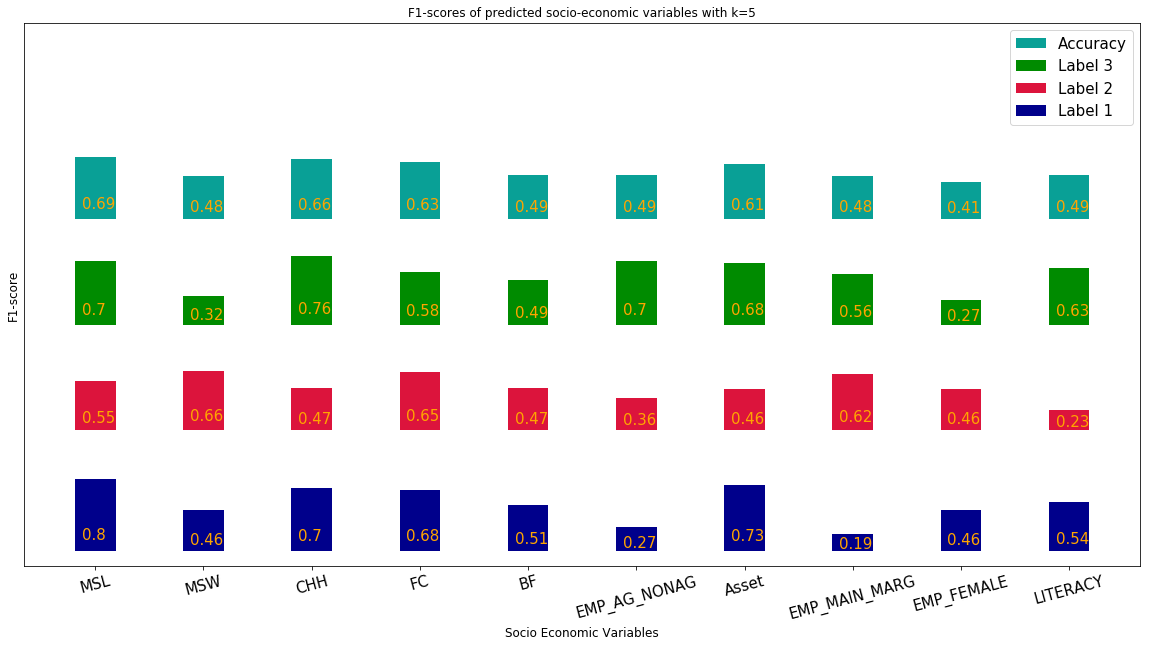

In [23]:
# plot of F1-scores after merging population census data
curr_k = 5
if_agri = 0

if if_agri:
    name = "log_acc_res_with_agri_"+str(curr_k)+".pickle"
else:
    name = "log_acc_res_without_agri_"+str(curr_k)+".pickle"

out_json = pickle.load(open(name,"rb"))

if if_agri:
    name = 'F1_scores_with_agri_k_'+str(curr_k)+'.png'
else:
    name = 'F1_scores_without_agri_k_'+str(curr_k)+'.png'

    
bold_font = FontProperties()
bold_font.set_size("large")

matplotlib.rcParams.update({'font.size': 15})

fig1 = plt.figure(figsize=(20,10))
ax1 = fig1.add_subplot(111)

ax1.set_ylim(0,18)
yticks = list()
ymajorLocator = matplotlib.ticker.FixedLocator(locs=yticks)
ymajorFormatter = matplotlib.ticker.ScalarFormatter()

ax1.yaxis.set_major_locator(ymajorLocator)
ax1.yaxis.set_major_formatter(ymajorFormatter)

labels = list(df_census.columns)
xticks = list(range(1,23,2))
xs = list(range(1,21,2))
xmajorLocator = matplotlib.ticker.FixedLocator(locs=xticks)
xmajorFormatter = matplotlib.ticker.ScalarFormatter(labels)
ax1.set_xticklabels(labels,rotation=15)
ax1.xaxis.set_major_locator(xmajorLocator)

width = 0.75
bot = [0.5,4.5,8,11.5]
legend_1,legend_2,legend_3,legend_4 = 0,0,0,0

i = 0
for k in df_census.columns:
    dik = out_json[k]["scores"]
    ax1.bar(xs[i],dik['4']*3,width,color="#09a096",bottom=bot[3],label="Accuracy" if not legend_4 else "")
    ax1.bar(xs[i],dik['3']*3,width,color="#008B00",bottom=bot[2],label="Label 3" if not legend_3 else "")
    ax1.bar(xs[i],dik['2']*3,width,color="#DC143C",bottom=bot[1],label="Label 2" if not legend_2 else "")
    ax1.bar(xs[i],dik['1']*3,width,color="#00008B",bottom=bot[0],label="Label 1" if not legend_1 else "")
    legend_1=1;legend_2=1;legend_3=1;legend_4=1
    ax1.text(xs[i]-width/3,bot[0]+dik['1']/2,dik['1'],color="orange")
    ax1.text(xs[i]-width/3,bot[1]+dik['2']/2,dik['2'],color="orange")
    ax1.text(xs[i]-width/3,bot[2]+dik['3']/2,dik['3'],color="orange")
    ax1.text(xs[i]-width/3,bot[3]+dik['4']/2,dik['4'],color="orange")
    
    i += 1


ax1.legend(loc='upper right')
ax1.set_xlabel('Socio Economic Variables',fontproperties=bold_font)
ax1.set_ylabel('F1-score',fontproperties=bold_font)
ax1.set_title('F1-scores of predicted socio-economic variables with k='+str(curr_k),fontproperties=bold_font)
fig1.savefig(name)


In [24]:
def color_negative_red(val):
    color = 'red' if val > 0.05 else 'black'
    return 'color: %s' % color
        
if if_agri:
    name = "log_acc_res_with_agri_"+str(curr_k)+".pickle"
else:
    name = "log_acc_res_without_agri_"+str(curr_k)+".pickle"

dik = pickle.load(open(name,"rb"))

foo_frame_p = pd.DataFrame(index=range(curr_k), columns=df_census.columns)
for sv in df_census.columns:
    p_values = dik[sv]["p_values"]
    for k in p_values:
        foo_frame_p.loc[k][sv] = p_values[k][1]

foo_frame_p_s = foo_frame_p.style.applymap(color_negative_red)
foo_frame_p_s

In [27]:
def posneg(val):
    color = "none"
     
    if val > 0:
        color = 'green'
    
    if val < 0:
        color = "red"
        
    if val == 0:
        color = "black"
    
    return 'color: %s' % color
        
if if_agri:
    name = "log_acc_res_with_agri_"+str(curr_k)+".pickle"
else:
    name = "log_acc_res_without_agri_"+str(curr_k)+".pickle"

dik = pickle.load(open(name,"rb"))

foo_frame_r = pd.DataFrame(index=range(curr_k), columns=df_census.columns)
for sv in df_census.columns:
    p_values = dik[sv]["p_values"]
    for k in p_values:
        if foo_frame_p.loc[k][sv] <= 0.05:
            foo_frame_r.loc[k][sv] = p_values[k][0]
        else:
            foo_frame_r.loc[k][sv] = 0

foo_frame_r = foo_frame_r.style.applymap(posneg)
foo_frame_r

In [75]:
if if_agri:
    name = "log_acc_res_with_agri_"+str(curr_k)+".pickle"
else:
    name = "log_acc_res_without_agri_"+str(curr_k)+".pickle"
    
dik = pickle.load(open(name,"rb"))
dik["clustering"]

{0: ['ARTS ENTERTAINMENT AND RECREATION'],
 1: ['AGRICULTURE  FORESTRY AND FISHING'],
 2: ['INFORMATION AND COMMUNICATION',
  'FINANCIAL AND INSURANCE ACTIVITIES',
  'REAL ESTATE ACTIVITIES',
  'ADMINISTRATIVE AND SUPPORT SERVICE ACTIVITIES'],
 3: ['MANUFACTURING'],
 4: ['WHOLESALE AND RETAIL TRADE REPAIR OF MOTORVEHICLES AND MOTORCYCLES',
  'OTHER SERVICE ACTIVITIES'],
 5: ['MINING AND QUARRYING',
  'ELECTRICITY GAS STEAM AND AIRCONDITION SUPPLY',
  'WATER SUPPLY SEWERAGE WASTE MANAGEMENT AND REMEDIATION ACTIVITIES',
  'CONSTRUCTION',
  'TRANSPORT AND STORAGE',
  'ACCOMODATION AND FOOD SERVICE ACTIVITIES',
  'PROFESSIONAL  SCIENTIFIC AND TECHNICAL ACTIVITIES',
  'EDUCATION',
  'HUMAN HEALTH AND SOCIAL WORK ACTIVITIES']}

In [133]:
# plot for relationship between employment vs articles count using Spearman correlation coefficient
# Spearman is used to measure the degree of association between two variables.
# The Spearman rank correlation test does not carry any assumptions about the distribution of the data.
load_frames(1,0)
a,b = df_art_abs.sum(axis=1),df_emp_abs.sum(axis=1)
sum_a, sum_b = sum(a),sum(b)
a,b = round(a*100/sum_a,2),round(b*100/sum_b,2)
pearsonr(a,b)

(0.38036970117530644, 8.9276231159119843e-07)

In [159]:
#find p values of employment vs articles, only for those with high article count
load_frames(0,0)
df_emp_abs = df_emp_abs[df_emp_abs.index.isin(common_dist_names)]
df_art_abs = df_art_abs[df_art_abs.index.isin(common_dist_names)]


# convert them to percent
total_emp_series = df_emp_abs.sum(axis=1)
df_emp_percent = df_emp_abs.div(total_emp_series,axis=0)*100
total_art_series = df_art_abs.sum(axis=1)
df_art_percent = df_art_abs.div(total_art_series,axis=0)*100

p_values = {}
# for i in df_art_percent.columns:
#     a,b = [],[]
#     if i == "15":
#         continue
#     for d_n in common_dist_names:
#         a.append(df_emp_percent.loc[d_n][i])
#         b.append(df_art_percent.loc[d_n][i])
#     p_values[i] = pearsonr(a,b)
# p_values
for d_n in common_dist_names:
    p_values[d_n] = pearsonr(df_emp_percent.loc[d_n],df_art_percent.loc[d_n])
    
confident = 0
for d_n in common_dist_names:
    if p_values[d_n][1] <= 0.05:
        print(d_n,p_values[d_n])
        

Amravati (0.7812258504358891, 7.8523723186200276e-05)
Warangal (0.49506177929892958, 0.031154827354125891)
Aurangabad (0.53955657705664539, 0.017113617043470343)
Azamgarh (0.72861531660855949, 0.00040301007935890707)
Latur (0.87172047107064665, 1.1651148398265269e-06)
Jalgaon (0.47356317927784225, 0.040552493328751944)
Gwalior (0.52616584078102935, 0.020661620337890919)
Karimnagar (0.46575067385253521, 0.044460229896211859)
Jamnagar (0.58664880483852744, 0.0082849343759455827)
Jhansi (0.50062479133569393, 0.029024626467650319)
Salem (0.47309243253396127, 0.040780195599180918)
Kolkata (0.46926008853568202, 0.042670698117414162)
Udaipur (0.52314514844996285, 0.021537113918642208)
Nanded (0.51234899206273521, 0.024908203462210558)
Tumkur (0.50066455883846417, 0.029009819487124073)
Junagadh (0.5195332625797211, 0.022622136100247797)
Shimoga (0.83712075817256426, 7.8389935913807023e-06)
Mirzapur (0.49467789835807668, 0.031306193352636631)
Ajmer (0.59637216441339913, 0.0070367963283333671)
S

In [ ]:
# HHI of employment
load_frames(0,0)
df_emp = df_emp_abs.copy()
df_emp = round(df_emp.div(df_emp.sum(axis=1), axis=0)*100,2)
df_foo = df_emp
df_foo = df_foo.apply(np.square)
df_foo["HHI"] = df_foo.sum(axis=1)
df_emp["HHI"] = round(df_foo["HHI"],2)

#HHI_emp analysis
print("Employment HHI Analysis")
print("Competitive :",len(df_emp[df_emp["HHI"]<=1800]))
print("Oligopoly :",len(df_emp[(df_emp["HHI"]>1800) & (df_emp["HHI"] <= 3000)]))
print("Monopoly :",len(df_emp[df_emp["HHI"]>3000]))

In [ ]:
# HHI of articles
df_art = df_art_abs.copy()
df_art = round(df_art.div(df_art.sum(axis=1), axis=0)*100,2)
df_foo = df_art
df_foo = df_foo.apply(np.square)
df_foo["HHI"] = df_foo.sum(axis=1)
df_art["HHI"] = round(df_foo["HHI"],2)

#HHI_emp analysis
print("Articles HHI Analysis")
print("Competitive :",len(df_art[df_art["HHI"]<=1800]))
print("Oligopoly :",len(df_art[(df_art["HHI"]>1800) & (df_art["HHI"] <= 3000)]))
print("Monopoly :",len(df_art[df_art["HHI"]>3000]))

In [102]:
#check which common district we have but are named differently or absent in census
different_names = set(common_dist_names).difference(set(list(df_census.index)))
print("Names different :",len(different_names))
for name in different_names:
    print(name)

print("These districts are not present in census data, forget them, move on! I am modifying common_dist_names now")
common_dist_names = set(common_dist_names).intersection(set(list(df_census.index)))
print("Common Dist names count :",len(common_dist_names))

Names different : 0
These districts are not present in census data, forget them, move on! I am modifying common_dist_names now
Common Dist names count : 157


In [163]:
#required for plotting HHI_plot.jpg
# common_dist_names = list(set(list(df_emp.index)).intersection(set(list(df_art.index))))
# #enumerate all districts
# dist_index_map = {}
# for e in enumerate(common_dist_names):
#     dist_index_map[e[0]] = e[1]

        
# if "HHI_plot.jpg" not in os.listdir('./'):
#     #0 for est_hhi, 1 for emp_hhi
#     hhi_indices = [[0,0,0] for _ in range(len(dist_index_map))]

#     for i in dist_index_map:
#         hhi_indices[i][0] = df_est.loc[dist_index_map[i]]["HHI"]
#         hhi_indices[i][1] = df_emp.loc[dist_index_map[i]]["HHI"]
#         hhi_indices[i][2] = df_art.loc[dist_index_map[i]]["HHI"]
# else:
#     print("Already plotted HHI_plot.jpg hence no need to run this cell")
    

In [164]:
# #final plotting
# if "HHI_plot.jpg" not in os.listdir('./'):
#     no_dists = len(common_dist_names)
#     fig1 = plt.figure(figsize=(500,20))
#     ax1 = fig1.add_subplot(111)
#     ax1.set_xlim(0,no_dists)
#     ax1.set_ylim(0,10500)
#     xticks = list(range(0,no_dists))
#     xmajorLocator = matplotlib.ticker.FixedLocator(locs=xticks) 
#     xmajorFormatter = matplotlib.ticker.ScalarFormatter()
#     ax1.xaxis.set_major_locator( xmajorLocator )
#     ax1.xaxis.set_major_formatter( xmajorFormatter )
#     ax1.bar(range(0,no_dists),list(map(lambda x : x[0],hhi_indices)),width=0.25,color="r",label="establishments")
#     ax1.bar(list(map(lambda x : x+0.25,list(range(0,no_dists)))),list(map(lambda x : x[1],hhi_indices)),width=0.25,color="g",label="total_employment")
#     ax1.bar(list(map(lambda x : x+0.5,list(range(0,no_dists)))),list(map(lambda x : x[2],hhi_indices)),width=0.25,color="blue",label="articles")
#     ax1.legend(loc='upper left')
#     ax1.set_title("Establishment vs Employment vs Articles HHI")
#     fig1.savefig("./HHI_plot.jpg")
# else:
#     print("Already plotted HHI_plot.jpg")

In [ ]:
# #make dataframe of dominating sectors for each district based on different HHI's
# df_dom_sec = pd.DataFrame(columns=['dom_est','dom_emp','dom_art'])

# for d_n in common_dist_names:
#     df_dom_sec.loc[d_n] = [df_est.loc[d_n][:-1].argmax(axis=1),df_emp.loc[d_n][:-1].argmax(axis=1),df_art.loc[d_n][:-1].argmax(axis=1)]

# print("Dominating sector in each district")
# df_dom_sec

In [ ]:
#est_hhi cdf
bin_hhi_est = df_est["HHI"]

# And finally plot the cdf
if "est_cdf.jpg" not in os.listdir("./"):
    fig2 = plt.figure(figsize=(20,10))
    ax2 = fig2.add_subplot(111)
    ax2 = bin_hhi_est.hist(cumulative=True, bins=20)
    xticks = list(range(500,10001,500))
    xmajorLocator = matplotlib.ticker.FixedLocator(locs=xticks) 
    xmajorFormatter = matplotlib.ticker.ScalarFormatter()
    ax2.xaxis.set_major_locator( xmajorLocator )
    ax2.xaxis.set_major_formatter( xmajorFormatter )
    ax2.set_title("CDF of Establishments HHI")
    ax2.set_xlabel("HHI")
    ax2.set_ylabel("No of Districts")
    fig2.savefig("est_cdf.jpg")
else:
    print("already plotted est_cdf.jpg")
    
print("...15 smallest HHI Establishment wise...")
smallest = bin_hhi_est.nsmallest(15)

for i in range(15):
    key = smallest.index[i]
    print('{:<25}  {:<10}  {:<10}'.format(key,smallest.loc[key],get_sector_name(df_est.loc[key][:-1].argmax(axis=1))))


print()
print()

print("...15 largest HHI Establishment wise...")
largest = bin_hhi_est.nlargest(15)

for i in range(15):
    key = largest.index[i]
    print('{:<25}  {:<10}  {:<10}'.format(key,largest.loc[key],get_sector_name(df_est.loc[key][:-1].argmax(axis=1))))



In [ ]:
#emp_hhi cdf
bin_hhi_emp = df_emp["HHI"]

# And finally plot the cdf
if "emp_cdf.jpg" not in os.listdir('./'):
    fig3 = plt.figure(figsize=(20,10))
    ax3 = fig3.add_subplot(111)
    ax3 = bin_hhi_emp.hist(cumulative=True, bins=20)
    xticks = list(range(500,10001,500))
    xmajorLocator = matplotlib.ticker.FixedLocator(locs=xticks) 
    xmajorFormatter = matplotlib.ticker.ScalarFormatter()
    ax3.xaxis.set_major_locator( xmajorLocator )
    ax3.xaxis.set_major_formatter( xmajorFormatter )
    ax3.set_title("CDF of Employment HHI")
    ax3.set_xlabel("HHI")
    ax3.set_ylabel("No of Districts")
    fig3.savefig("emp_cdf.jpg")
else:
    print("alredy plotted emp_cdf.jpg")
    
print("...15 smallest HHI Employment wise...")
smallest = bin_hhi_emp.nsmallest(15)

for i in range(15):
    key = smallest.index[i]
    print('{:<25}  {:<10}  {:<10}'.format(key,smallest.loc[key],get_sector_name(df_emp.loc[key][:-1].argmax(axis=1))))


print()
print()

print("...15 largest HHI Employment wise...")
largest = bin_hhi_emp.nlargest(15)

for i in range(15):
    key = largest.index[i]
    print('{:<25}  {:<10}  {:<10}'.format(key,largest.loc[key],get_sector_name(df_emp.loc[key][:-1].argmax(axis=1))))



In [ ]:
#emp_hhi cdf
bin_hhi_art = df_art["HHI"]

# And finally plot the cdf
if "art_cdf.jpg" not in os.listdir('./'):
    fig4 = plt.figure(figsize=(20,10))
    ax4 = fig4.add_subplot(111)
    ax4 = bin_hhi_art.hist(cumulative=True, bins=20)
    xticks = list(range(500,10001,500))
    xmajorLocator = matplotlib.ticker.FixedLocator(locs=xticks) 
    xmajorFormatter = matplotlib.ticker.ScalarFormatter()
    ax4.xaxis.set_major_locator( xmajorLocator )
    ax4.xaxis.set_major_formatter( xmajorFormatter )
    ax4.set_title("CDF of HHI Article wise")
    ax4.set_xlabel("HHI")
    ax4.set_ylabel("No of Districts")
    fig4.savefig("art_cdf.jpg")
else:
    print("already plotted art_cdf.jpg")

print("...15 smallest HHI Articles wise...")
smallest = bin_hhi_art.nsmallest(15)

for i in range(15):
    key = smallest.index[i]
    print('{:<25}  {:<10}  {:<10}'.format(key,smallest.loc[key],get_sector_name(df_art.loc[key][:-1].argmax(axis=1))))


print()
print()

print("...15 largest HHI Articles wise...")
largest = bin_hhi_art.nlargest(15)

for i in range(15):
    key = largest.index[i]
    print('{:<25}  {:<10}  {:<10}'.format(key,largest.loc[key],get_sector_name(df_art.loc[key][:-1].argmax(axis=1))))



In [ ]:
#total articles for a district analysis
dist_art_count = pd.Series()
data = runsql("select district_id,count(*) as total from dist_sect_articles group by district_id")

for i in data:
    dist_art_count.loc[get_dist_name(i[0])] = i[1]

dist_art_less = dist_art_count[dist_art_count < 100]
dist_art_great = dist_art_count[dist_art_count>=300]

if "art_count_great_cdf.jpg" not in os.listdir('./'):
    fig5 = plt.figure(figsize=(20,10))
    ax5 = fig5.add_subplot(111)
    ax5 = dist_art_great.hist(cumulative=True, bins=100,grid=True)
    ax5.set_title("CDF of Article Count District wise with count>=300")
    ax5.set_xlabel("Count")
    ax5.set_ylabel("No of Districts")
    fig5.savefig("art_count_great_cdf.jpg")
else:
    print("already plotted art_count_great_cdf.jpg")

if "art_count_less_cdf.jpg" not in os.listdir('./'):
    fig6 = plt.figure(figsize=(20,10))
    ax6 = fig6.add_subplot(111)
    ax6 = dist_art_less.hist(cumulative=True, bins=20,ec='black',grid=False)
    ax6.set_title("CDF of Article Count District wise with count<100")
    ax6.set_xlabel("Count")
    ax6.set_ylabel("No of Districts")
    fig6.savefig("art_count_less_cdf.jpg")
else:
    print("already plotted art_count_less_cdf.jpg")


print("No. of districts having less than 100 articles : "+str(len(dist_art_less)))
print("No. of districts having greater than 300 articles : " + str(len(dist_art_count[dist_art_count>300])))
print("No. of districts having greater than 1000 articles : "+str(len(dist_art_count[dist_art_count>1000])))

In [ ]:
#total articles for a district by year analysis
year_wise_more_than_threshold = {2011:set(),2012:set(),2013:set(),2014:set(),2015:set(),2016:set(),2017:set()}

years = ["2011","2012","2013","2014","2015","2016","2017"]

threshold = 50

for year in years:
    dist_art_count_year = pd.Series()
    data = runsql("select district_id,count(*) from dist_sect_articles where year = "+"\""+year+"\""+"group by district_id")
    for i in data:
        dist_art_count_year[get_dist_name(i[0])] = i[1]
    
    year_wise_more_than_threshold[year] = set(dist_art_count_year[dist_art_count_year>=threshold].index)
    
    dist_count_year = len(dist_art_count_year)
    print("No. of Districts for which articles exist in year "+year+" : "+str(dist_count_year))
    
    if "art_count_"+year+"_cdf.jpg" not in os.listdir("./"):
        fig7 = plt.figure(figsize=(20,10))
        ax7 = fig7.add_subplot(111)
        ax7 = dist_art_count_year.hist(cumulative=True, bins=50)
        ax7.set_title("CDF of Article Count District wise for year "+str(year))
        ax7.set_xlabel("Article Count")
        ax7.set_ylabel("No of Districts")
        fig7.savefig("art_count_"+year+"_cdf.jpg")
    else:
        print("already plotted art_count_"+year+"_cdf.jpg")


In [ ]:
print("For each year, no. of districts having articles >"+str(threshold)+" and total articles in that year")
for year in years:
    print(year," : ",len(year_wise_more_than_threshold[year])," : ",runsql("select count(*) from dist_sect_articles where year = "+"\""+year+"\"")[0][0])
prominent_dist = year_wise_more_than_threshold["2011"]
for year in years[1:4]:
    prominent_dist = prominent_dist.intersection(year_wise_more_than_threshold[year])
print("\n\nTotal common districts from 2011 to 2014 : ",len(prominent_dist))
prominent_dist

In [ ]:
sector_presence_est = [0]*19
# for i in range(1,20):
#     sector_presence_est[i-1] = 0
    
for d_n in df_est.index:
    for c_n in df_est.columns[:-1]:
        if df_est.loc[d_n][c_n] >= 5:
            sector_presence_est[int(c_n)-1] += 1
            
print("Sectors' presence across districts Establishment-wise\n")
for i in range(1,20):
    print('{:<70}  {:<10}'.format(get_sector_name(i),sector_presence_est[i-1])) 

if "sector_presence_est.jpg" not in os.listdir("./"):
    fig8 = plt.figure(figsize=(20,10))
    ax8 = fig8.add_subplot(111)
    xticks = list(range(1,20))
    xmajorLocator = matplotlib.ticker.FixedLocator(locs=xticks) 
    xmajorFormatter = matplotlib.ticker.ScalarFormatter()
    ax8.xaxis.set_major_locator( xmajorLocator )
    ax8.xaxis.set_major_formatter( xmajorFormatter )
    ax8.bar(range(1,20),sector_presence_est)
    ax8.set_title("Sectors' presence across districts Establishment-wise")
    ax8.set_xlabel("Sector_id")
    ax8.set_ylabel("No of Districts")
    fig8.savefig("sector_presence_est.jpg")
else:
    print("\nalready plotted sector_presence_est.jpg")


In [ ]:
sector_presence_emp = [0]*19
for d_n in df_emp.index:
    for c_n in df_emp.columns[:-1]:
        if df_emp.loc[d_n][c_n] >= 5:
            sector_presence_emp[int(c_n)-1] += 1
            
print("Sectors' presence across districts Employment-wise\n")
for i in range(1,20):
    print('{:<70}  {:<10}'.format(get_sector_name(i),sector_presence_emp[i-1]))  
    
if "sector_presence_emp.jpg" not in os.listdir("./"):
    fig9 = plt.figure(figsize=(20,10))
    ax9 = fig9.add_subplot(111)
    xticks = list(range(1,20))
    xmajorLocator = matplotlib.ticker.FixedLocator(locs=xticks) 
    xmajorFormatter = matplotlib.ticker.ScalarFormatter()
    ax9.xaxis.set_major_locator( xmajorLocator )
    ax9.xaxis.set_major_formatter( xmajorFormatter )
    ax9.bar(range(1,20),sector_presence_emp)
    ax9.set_title("Sectors' presence across districts Employment-wise")
    ax9.set_xlabel("Sector_id")
    ax9.set_ylabel("No of Districts")
    fig9.savefig("sector_presence_emp.jpg")
else:
    print("\nalready plotted sector_presence_emp.jpg")


In [ ]:
sector_presence_art = [0]*19
for d_n in df_art.index:
    for c_n in df_art.columns[:-1]:
        if df_art.loc[d_n][c_n] >= 5:
            sector_presence_art[int(c_n)-1] += 1
            
print("Sectors' presence across districts Articles-wise\n")
for i in range(1,20):
    print('{:<70}  {:<10}'.format(get_sector_name(i),sector_presence_art[i-1]))  
if "sector_presence_art.jpg" not in os.listdir('./'):
    fig10 = plt.figure(figsize=(20,10))
    ax10 = fig10.add_subplot(111)
    xticks = list(range(1,20))
    xmajorLocator = matplotlib.ticker.FixedLocator(locs=xticks) 
    xmajorFormatter = matplotlib.ticker.ScalarFormatter()
    ax10.xaxis.set_major_locator( xmajorLocator )
    ax10.xaxis.set_major_formatter( xmajorFormatter )
    ax10.bar(range(1,20),sector_presence_art)
    ax10.set_title("Sectors' presence across districts Articles-wise")
    ax10.set_xlabel("Sector_id")
    ax10.set_ylabel("No of Districts")
    fig10.savefig("sector_presence_art.jpg")
else:
    print("\nalready plotted sector_presence_art.jpg")



In [ ]:
# plot for districts having articles less than 50
dist_art_less_50 = dist_art_count[dist_art_count<50]

if "art_count_less_50_cdf.jpg" not in os.listdir('./'):
    fig11 = plt.figure(figsize=(20,10))
    ax11 = fig11.add_subplot(111)
    ax11 = dist_art_less.hist(cumulative=True, bins=20,ec='black',grid=False)
    ax11.set_title("CDF of Article Count District wise with count<100")
    ax11.set_xlabel("Count")
    ax11.set_ylabel("No of Districts")
    fig11.savefig("art_count_less_50_cdf.jpg")
else:
    print("already plotted art_count_less_50_cdf.jpg")


print("No. of districts having less than 50 articles : "+str(len(dist_art_less_50)))

In [ ]:
# #see the difference between .154 and .25 Media databases
# from pymongo import MongoClient
# client1 = MongoClient('mongodb://10.237.26.25:27017')
# articles1 = client1['media-db']['articles']
# client2 = MongoClient('mongodb://10.237.26.154:27017')
# articles2 = client1['media-db']['articles']

# yearwise_article_counts = {1:{},2:{}}
# years = ["2011","2012","2013","2014","2015","2016","2017"]

# temp = 0
# for year in years[0:1]:
#     temp = 0
# #     gen1 = articles1.find({'publishedDate':{"$regex":year}})
# #     for _ in gen1:
# #         temp += 1
# #     yearwise_article_counts[1][year] = temp
#     temp = 0
#     gen2 = articles2.find({'publishedDate':{"$regex":year}})
#     for _ in gen2:
#         temp += 1
#     yearwise_article_counts[2][year] = temp
    
    
# # print("yearwise_articles in original : 10.237.26.25")
# # print(yearwise_article_counts[1])
# # print()
# # print("yearwise_articles in first copy : 10.237.26.154")
# # print(yearwise_article_counts[2])

MSL MSW CHH FC BF EMP_AG_NONAG Asset EMP_MAIN_MARG  \
District Name                                                                
Kupwara                   3   1   3  1  1            1     1             1   
Budgam                    3   3   2  1  3            1     2             1   
Leh                       3   1   2  3  2            3     2             2   
Kargil                    3   3   3  1  3            3     1             3   
Punch                     3   1   2  1  1            1     1             3   
Rajouri                   3   1   2  1  1            2     1             3   
Kathua                    3   3   1  1  1            1     2             1   
Baramulla                 3   3   2  1  3            1     2             1   
Bandipora                 3   3   2  1  3            1     1             3   
Srinagar                  3   3   1  3  3            3     3             1   
Ganderbal                 3   3   2  1  3            1     2             3   
Pulwama                   3   3   2  1  3            1     2             3   
Shupiyan                  3   3   2  1  3            1     2             1   
Anantnag                  3   3   2  1  1            1     1             3   
Kulgam                    2   3   2  1  1            1     2             3   
Doda                      3   3   2  1  1            1     1             3   
Ramban                    2   3   2  1  1            1     1             1   
Kishtwar                  3   3   2  1  1            1     1             3   
Udhampur                  3   3   1  1  1            3     2             3   
Reasi                     2   3   2  1  1            2     1             3   
Jammu                     3   3   1  3  3            3     3             1   
Samba                     3   3   1  3  1            3     2             1   
Chamba                    3   3   1  1  3            2     2             3   
Kangra                    3   3   1  3  3            1     2             3   
Lahul & Spiti             3   3   1  1  2            2     2             2   
Kullu                     3   3   1  3  3            2     2             2   
Mandi                     3   3   1  1  3            2     2             3   
Hamirpur                  3   3   1  1  3            2     2             3   
Una                       3   3   1  1  3            1     2             3   
Bilaspur                  3   3   1  1  3            2     2             3   
...                      ..  ..  .. .. ..          ...   ...           ...   
Nilgiris                  3   3   1  3  1            3     2             2   
Dindigul                  3   3   1  1  1            2     2             2   
Karur                     3   3   1  3  1            2     2             2   
Tiruchirappalli           3   3   1  3  3            3     2             2   
Perambalur                3   3   1  1  1            2     2             2   
Ariyalur                  3   3   1  1  1            2     2             2   
Cuddalore                 3   3   1  3  1            1     2             1   
Nagapattinam              3   3   2  1  1            1     2             1   
Thiruvarur                3   3   2  1  1            1     2             1   
Thanjavur                 3   3   1  1  3            1     2             1   
Pudukkottai               3   3   1  1  1            2     2             2   
Sivaganga                 3   3   1  1  1            1     2             2   
Madurai                   3   3   1  3  3            3     2             2   
Theni                     3   3   1  3  1            2     2             2   
Virudhunagar              3   3   1  3  1            3     2             2   
Ramanathapuram            3   3   1  1  1            1     2             2   
Thoothukudi               3   3   1  3  3            3     2             2   
Tirunelveli               3   3   1  3  1            3     2             2   
Kanyakumari               3   3   1  1  2     

Names different : 1
Delhi
These districts are not present in census data, forget them, move on! I am modifying common_dist_names now
Common Dist names count : 104


In [ ]:
# Dictionary containing Sector-wise set of all districts having >=10% employment
dom_sec_dik = {}
for i in range(19):
    dom_sec_dik[str(i+1)] = set()

for d_n in common_dist_names:
    for sec in range(1,20):
        try:
            if df_emp.loc[d_n][str(sec)] >= 10:
                dom_sec_dik[str(sec)].add(d_n)
        except:
            pass
lens = []
for i in range(1,20):
    if len(dom_sec_dik[str(i)])>40:
        lens.append(str(i))
print("Sectors having employment dominance in more than 40 districts :",lens)

#lets call them useful sectors
useful_sectors = list(lens)

In [ ]:
#Finding relation between employment-wise dominant sector and socio-economic variables of a district

#change sector no and name here to reproduce results
sec_no,sec_name = "7","Wholesale & Retail Trade"
main_dik = {}

for col in df_census.columns:
    temp_dic = {"1":0,"2":0,"3":0}
    for d in dom_sec_dik[sec_no]:
        try:
            temp_dic[df_census.loc[d][col]] += 1
        except:
            pass
    main_dik[col] = temp_dic
    
# #convert to percentage
for k in main_dik:
    temp_dic = main_dik[k]
    tot = sum(temp_dic.values())
    for _k in temp_dic:
        temp_dic[_k] = round(temp_dic[_k]*100/tot,1)

# See how many districts are analysed
count = len(dom_sec_dik[sec_no])
print("Analysed districts :",count)
    
main_dik

In [ ]:
#plot for each sector, change the name
name = "emp_wh&rt_var.jpg"
if name not in os.listdir("./"):
    #common
    from matplotlib.font_manager import FontProperties
    bold_font = FontProperties()
    # bold_font.set_weight('bold')
    bold_font.set_size("large")

    fig13 = plt.figure(figsize=(20,10))
    ax13 = fig13.add_subplot(111)
    width = 0.75
    xs = range(1,21,2)
    xticks = range(1,21,2)
    labels = list(df_census.columns) 
    xmajorLocator = matplotlib.ticker.FixedLocator(xticks)
    xmajorFormatter = matplotlib.ticker.FixedFormatter(labels)
    ax13.xaxis.set_major_locator( xmajorLocator )
    # ax13.xaxis.set_major_formatter( xmajorFormatter)
    ax13.set_xticklabels(labels,weight="bold",rotation=0)
    ax13.set_xlim(0,20)
    ax13.set_title(sec_name + " Affecting Socio-Economic variables",weight="bold")

    #dictionary specific plotting
    #maufacturing vs MSL
    i = 0
    for k in main_dik:
        dik = main_dik[k]
        ax13.bar(xs[i],dik['1'],width,color="#131A55")
        ax13.bar(xs[i],dik['2'],width,color="#1B277C",bottom=dik['1'])
        ax13.bar(xs[i],dik['3'],width,color="#274B93",bottom=dik['1']+dik['2'])
        ax13.text(xs[i]-width/3,dik['1']/2,dik['1'],color="white",fontproperties=bold_font)
        ax13.text(xs[i]-width/3,dik['1']+dik['2']/2,dik['2'],color="white",fontproperties=bold_font)
        ax13.text(xs[i]-width/3,dik['1']+dik['2']+dik['3']/2,dik['3'],color="white",fontproperties=bold_font)
        i += 1

    fig13.savefig(name)
    print("Plotted",name)
else:
    print("Plot already exists")


In [ ]:
#it plots a graph which we needed for midterm presentations
# if "try.jpg" not in os.listdir("./"):
#     y = range(19)
#     x1 = sector_presence_emp
#     x2 = sector_presence_art

#     fig12, axes = plt.subplots(ncols=2, sharey=True, figsize=(10,10))
#     axes[0].barh(y, x1, align='center', color='red')
#     axes[0].set(title='Employment-wise presence')
#     axes[1].barh(y, x2, align='center', color='blue')
#     axes[1].set(title='Article-wise presence')
#     axes[0].invert_xaxis()
#     for yloc, state in zip(y, y):
#         axes[0].annotate(state+1, (0.5, yloc), xycoords=('figure fraction', 'data'),
#                          ha='center', va='center')

#     yticks = list(range(1,1))
#     ymajorLocator = matplotlib.ticker.FixedLocator(locs=yticks) 
#     ymajorFormatter = matplotlib.ticker.ScalarFormatter()
#     axes[0].yaxis.set_major_locator( ymajorLocator )
#     axes[0].yaxis.set_major_formatter( ymajorFormatter )
#     axes[0].yaxis.tick_right()
#     fig12.suptitle('Comparision between 6th_Eco_Census and MassMedia', fontsize=20)
#     fig12.savefig("try.jpg")
# else:
#     print("Already plotted try.jpg")

In [ ]:
#Read nighlights csv
df_night = pd.read_csv("./nightlights.csv",index_col=False,dtype=str)
df_night.set_index('DISTRICT',inplace=True)
df_night

In [ ]:
night_growth_dik = {}
night_devp_dik = {}

for sector in useful_sectors:
    night_growth_dik[sector] = [0,0]
    night_devp_dik[sector] = [0,0,0,0]

for sector in useful_sectors:
    dists = dom_sec_dik[sector]
    for d in dists:
        try:
            growth = df_night.loc[d]["growth"]
            devp = df_night.loc[d]["devp"]
            
            if growth.strip() == "Non Growing":
                night_growth_dik[sector][0] += 1
            
            if growth.strip() == "Growing":
                night_growth_dik[sector][1] += 1
            
            night_devp_dik[sector][int(devp)-1] += 1
        except:
            pass

#normalize night_growth_dik
for k in night_growth_dik:
    tup = night_growth_dik[k]
    tot = sum(tup)
    tup[0] = round(tup[0]*100/tot,1)
    tup[1] = round(tup[1]*100/tot,1)

    
#normalize night_growth_dik
for k in night_devp_dik:
    tup = night_devp_dik[k]
    tot = sum(tup)
    tup[0] = round(tup[0]*100/tot,1)
    tup[1] = round(tup[1]*100/tot,1)
    tup[2] = round(tup[2]*100/tot,1)
    tup[3] = round(tup[3]*100/tot,1)
    
    
print(night_growth_dik)
print(night_devp_dik)

In [ ]:
#plot sector_growth.jpg
name = "sector_growth.jpg"
if name not in os.listdir("./"):
    #common
    from matplotlib.font_manager import FontProperties
    bold_font = FontProperties()
    # bold_font.set_weight('bold')
    bold_font.set_size("large")

    fig14 = plt.figure(figsize=(20,10))
    ax14 = fig14.add_subplot(111)
    width = 0.75
    xs = range(1,9,2)
    xticks = range(1,9,2)
    labels = list(useful_sectors) 
    xmajorLocator = matplotlib.ticker.FixedLocator(xticks)
    xmajorFormatter = matplotlib.ticker.FixedFormatter(labels)
    ax14.xaxis.set_major_locator( xmajorLocator )
    # ax14.xaxis.set_major_formatter( xmajorFormatter)
    ax14.set_xticklabels(labels,weight="bold",rotation=0)
    ax14.set_xlim(0,10)
    ax14.set_title("Sector vs Growth",weight="bold")

    #dictionary specific plotting
    i = 0
    for k in night_growth_dik:
        tup = night_growth_dik[k]
        ax14.bar(xs[i],tup[0],width,color="#131A55")
        ax14.bar(xs[i],tup[1],width,color="#274B93",bottom=tup[0])
#         ax14.bar(xs[i],dik['3'],width,color="#274B93",bottom=dik['1']+dik['2'])
        ax14.text(xs[i]-width/3,tup[0]/2,tup[0],color="white",fontproperties=bold_font)
        ax14.text(xs[i]-width/3,tup[0]+tup[1]/2,tup[1],color="white",fontproperties=bold_font)
#         ax13.text(xs[i]-width/3,dik['1']+dik['2']+dik['3']/2,dik['3'],color="white",fontproperties=bold_font)
        i += 1
    
    s = "3 - Manufacturing\n7 - Wholesale And Retail Trade\n16 - Education\n17 - Human Health and Social Work" 
    bold_font.set_size("x-large")
    ax14.text(7.5,80,s,bbox=dict(facecolor='white',alpha=1.0),fontproperties=bold_font)
    fig14.savefig(name)
    print("Plotted",name)
else:
    print("Plot already exists")

In [ ]:
#plot sector_nightlights.jpg
name = "sector_nightlights.jpg"
if name not in os.listdir("./"):
    #common
    from matplotlib.font_manager import FontProperties
    bold_font = FontProperties()
    # bold_font.set_weight('bold')
    bold_font.set_size("large")

    fig15 = plt.figure(figsize=(20,10))
    ax15 = fig15.add_subplot(111)
    width = 0.75
    xs = range(1,9,2)
    xticks = range(1,9,2)
    labels = list(useful_sectors) 
    xmajorLocator = matplotlib.ticker.FixedLocator(xticks)
    xmajorFormatter = matplotlib.ticker.FixedFormatter(labels)
    ax15.xaxis.set_major_locator( xmajorLocator )
    # ax14.xaxis.set_major_formatter( xmajorFormatter)
    ax15.set_xticklabels(labels,weight="bold",rotation=0)
    ax15.set_xlim(0,10)
    ax15.set_title("Sector vs Nightlights",weight="bold")

    #dictionary specific plotting
    i = 0
    for k in night_devp_dik:
        tup = night_devp_dik[k]
        ax15.bar(xs[i],tup[0],width,color="#141C5B")
        ax15.bar(xs[i],tup[1],width,color="#1B3183",bottom=tup[0])
        ax15.bar(xs[i],tup[2],width,color="#2E58A4",bottom=tup[0]+tup[1])
        ax15.bar(xs[i],tup[3],width,color="#3883BC",bottom=tup[0]+tup[1]+tup[2])
#         ax15.bar(xs[i],dik['3'],width,color="#274B93",bottom=dik['1']+dik['2'])
        ax15.text(xs[i]-width/4,tup[0]/2,tup[0],color="white",fontproperties=bold_font)
        ax15.text(xs[i]-width/4,tup[0]+tup[1]/2,tup[1],color="white",fontproperties=bold_font)
        ax15.text(xs[i]-width/4,tup[0]+tup[1]+tup[2]/2,tup[2],color="white",fontproperties=bold_font)
        ax15.text(xs[i]-width/4,tup[0]+tup[1]+tup[2],tup[3],color="white")
#         ax15.text(xs[i]-width/3,dik['1']+dik['2']+dik['3']/2,dik['3'],color="white",fontproperties=bold_font)
        i += 1
    
    s = "3 - Manufacturing\n7 - Wholesale And Retail Trade\n16 - Education\n17 - Human Health and Social Work" 
    bold_font.set_size("x-large")
    ax15.text(7.5,80,s,bbox=dict(facecolor='white',alpha=1.0),fontproperties=bold_font)
    fig15.savefig(name)
    print("Plotted",name)
else:
    print("Plot already exists")

In [ ]:
#2-factor analysis generation and plot
df_emp_abs = pd.read_csv("./dist_sect_emp_frame.csv",index_col=0)
socio_vars = df_census.columns

from matplotlib.font_manager import FontProperties
bold_font = FontProperties(size="x-large")

size = 3

for socio_var in socio_vars:
    name = "2_factor_analysis_" + socio_var + ".jpg"
    
    if name not in os.listdir("./"):
        aggre_emp = np.zeros((size,19))

        for d_n in common_dist_names:
            try:
                d_label = int(df_census.loc[d_n][socio_var])
                d_emp = np.array(df_emp_abs.loc[d_n].apply(lambda x : int(x)))
                aggre_emp[d_label-1] += d_emp
            except:
                pass

        for  i in range(19):
            aggre_emp[:,i] = aggre_emp[:,i]/sum(aggre_emp[:,i])*100

       
        fig16 = plt.figure(figsize=(20,10))
        ax16 = fig16.add_subplot(111)

        ax16.set_xlim(-1,20)
        ax16.set_ylim(0,105)

        xticks = range(1,20,1)
        labels = list(range(1,20))
        xmajorLocator = matplotlib.ticker.FixedLocator(xticks)
        xmajorFormatter = matplotlib.ticker.FixedFormatter(labels)
        ax16.xaxis.set_major_locator( xmajorLocator )
        ax16.set_xticklabels(labels,weight="bold",size="x-large",rotation=0)
        ax16.set_title("2-Factor Analysis for " + socio_var,weight="bold",size="xx-large")

        legend_1,legend_2,legend_3 = 0,0,0
        xs = list(range(1,20,1))
        for i in range(len(xs)):
            x = xs[i]
            arr = list(aggre_emp[:,i])
            ax16.bar(x,arr[0],color="#00008B",label="1" if not legend_1 else "")
            ax16.text(x-1/3,arr[0]/2,str(round(arr[0],1)),color="white",fontproperties=bold_font)
            legend_1 = 1

            ax16.bar(x,arr[1],bottom=arr[0],color="#DC143C",label="2" if not legend_2 else "")
            ax16.text(x-1/3,arr[0]+arr[1]/2,str(round(arr[1],1)),color="white",fontproperties=bold_font)
            legend_2 = 1

            ax16.bar(x,arr[2],bottom=arr[1]+arr[0],color="#008B00",label="3" if not legend_3 else "")
            ax16.text(x-1/3,arr[0]+arr[1]+arr[2]/2,str(round(arr[2],1)),color="white",fontproperties=bold_font)
            legend_3 = 1

        ax16.legend() 
        fig16.savefig(name)
    else:
        print("2_factor_analysis_" + socio_var + ".jpg plot already exists")


In [ ]:
# #Logistic Regression to see if sectoral employment distribution can predict the label of a given socio-var

# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import precision_recall_fscore_support
# name = "log_acc_coeff.csv"
# out = ""
# np.set_printoptions(suppress=True)
# if name not in os.listdir("./"):
#     features = []
#     labels = []

#     for d_n in common_dist_names:
#         try:
#             temp_feature = list(df_emp.loc[d_n][:-1])
#             temp_label = list(map(lambda x: int(x),list(df_census.loc[d_n])))
#             features.append(temp_feature)
#             labels.append(temp_label)
#         except:
#             continue

#     assert len(features) == len(labels)

#     j = 0
#     for socio_var in df_census.columns:
#         out += 'Socio-Economic Variable,'+ socio_var
        
#         x_train, x_test, y_train, y_test = train_test_split(features,list(map(lambda x : x[j],labels)), test_size=0.2, random_state=42)

#         logreg = LogisticRegression(solver='lbfgs', multi_class='multinomial')
#         logreg.fit(x_train, y_train)
        
#         #list conversion necessary for count
#         y_test = list(y_test)

#         y_pred = logreg.predict(x_test)
        
#         acc = round(np.sum(y_pred == y_test)/len(y_test),2)
        
#         precision, recall, fscore, support = precision_recall_fscore_support(y_test,y_pred)
        
#         precision = list(map(lambda x : round(x,2),precision))
#         recall = list(map(lambda x : round(x,2),recall))
#         fscore = list(map(lambda x : round(x,2),fscore))
        
        
#         out += '\nAccuracy,' + str(acc)
#         out += '\nDistribution,1 - ' + str(round(y_test.count(1)/len(y_test),2)) + ",2 - " + str(round(y_test.count(2)/len(y_test),2)) + ",3 - " + str(round(y_test.count(3)/len(y_test),2))
#         out += '\n\nLabel,Precision,Recall,F1-Score'
#         out += '\n1,' + str(precision[0]) + ',' + str(recall[0]) + ',' + str(fscore[0])
#         out += '\n2,' + str(precision[1]) + ',' + str(recall[1]) + ',' + str(fscore[1])
#         out += '\n3,' + str(precision[2]) + ',' + str(recall[2]) + ',' + str(fscore[2])
#         out += '\n\n' + str(np.round(logreg.coef_,2))
        
#         out += '\n\n'
#         j += 1
#     with open(name,'w') as f:
#         f.write(out)
# else:
#     print("log_acc_coeff.csv already exists")
